NAME: M NISHANTH MAURYA
  
  REG NUM: 191EC226
  
  


### Q.1. Implement CNN(VGG16) model using Keras/Tensorflow library for Steel Defect Detection 

#### Dataset: <a>https://www.kaggle.com/c/severstal-steel-defect-detection/data</a>

#### For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Binary cross entropy loss function. For better training performance, you can use batch-normalization and dropout if necessary.

#### (i)Plot a comparative loss curve for at least 50 epochs 
#### (ii) Print confusion matrix, calculate classification metrics such as precision, recall, F1-score, IoU and accuracy on test dataset and ROC curve.

In [ ]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

from PIL import Image

import tensorflow as tf 
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split 

import os 
from tqdm import * 
import pandas as pd 

data_path = "Q1_dataset/train.csv" 

In [ ]:
tf.config.list_physical_devices("GPU")

2021-11-09 15:39:42.322942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:42.329274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:42.329625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
filePaths = pd.read_csv(data_path)

_image_paths = list(filePaths["ImageId"])
image_paths = [os.path.join("Q1_dataset/train_images", i) for i in tqdm(_image_paths, desc = "Loading image paths", ncols=100)]

df = filePaths
df["ImageId"] = image_paths
df.head()

Loading image paths: 100%|█████████████████████████████████| 7095/7095 [00:00<00:00, 1075482.00it/s]


ImageId  ClassId  \
0  Q1_dataset/train_images/0002cc93b.jpg        1   
1  Q1_dataset/train_images/0007a71bf.jpg        3   
2  Q1_dataset/train_images/000a4bcdd.jpg        1   
3  Q1_dataset/train_images/000f6bf48.jpg        4   
4  Q1_dataset/train_images/0014fce06.jpg        3   

                                       EncodedPixels  
0  29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1  18661 28 18863 82 19091 110 19347 110 19603 11...  
2  37607 3 37858 8 38108 14 38359 20 38610 25 388...  
3  131973 1 132228 4 132483 6 132738 8 132993 11 ...  
4  229501 11 229741 33 229981 55 230221 77 230468...

In [ ]:
EPOCHS = 50 
LR = 0.01 
BATCH_SIZE = 32 

img = cv2.imread(image_paths[0])
# (HEIGHT, WIDTH, CHANNELS) = img.shape
HEIGHT = WIDTH = 256 
CHANNELS = 1

In [ ]:
class SteelDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, dim = (HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):

        self.data = df 
        self.batch_size = batch_size 
        self.idx = self.data.index.tolist()
        self.dim = dim 

        self.channels = n_channels
        self.shuffle = shuffle 
        self.min_depth = 0.1 

        self.on_epoch_end() 

    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size)) 

    def __getitem__(self, idx):
        if (idx+1)*self.batch_size > len(self.idx):
            self.batch_size = len(self.idx) - idx*self.batch_size 

        idx = self.idx[idx*self.batch_size : (idx+1)*self.batch_size] 
        batch = [self.idx[k] for k in idx]
        x, y = self.__data_generation(batch)
        return x, y 

    def on_epoch_end(self):
        self.idx = np.arange(len(self.idx)) 
        if self.shuffle:
            np.random.shuffle(self.idx) 

    def rle2mask(self, rle, imgshape):
        w, h = imgshape
        mask = np.zeros(w*h).astype(np.uint8)

        arr = np.asarray([int(x) for x in rle.split()])
        starts = arr[0::2]
        lens = arr[1::2] 

        currPos = 0
        for idx, start in enumerate(starts):
            mask[int(start) : int(start+lens[idx])] = 1
            currPos += lens[idx] 
        return np.flipud(np.rot90(mask.reshape(h, w), k=1))


    def load_img(self, img_path):
        img = np.asarray(Image.open(img_path))/256.
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img = tf.image.convert_image_dtype(img, tf.float32)
        return img[:,:,0]


    def __data_generation(self, batch):
        x = np.empty((self.batch_size, *self.dim, self.channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for idx, batch_idx in enumerate(batch):
            img = self.load_img(self.data["ImageId"][batch_idx])
            mask = self.rle2mask(self.data["EncodedPixels"][batch_idx], img.shape)
            # mask = np.expand_dims(mask, -1)
            img = np.expand_dims(cv2.resize(img, (HEIGHT, WIDTH)), -1)
            x[idx, :] = tf.image.convert_image_dtype(img, tf.float32)
            mask = np.expand_dims(cv2.resize(mask, (HEIGHT, WIDTH)), -1)
            y[idx, :] = tf.image.convert_image_dtype(mask, tf.uint8)

            # x[idx, :] = img
            # y[idx, :] = mask 

        return x, y 
        

In [ ]:
def visualize(samples, n_samples, model=None):
    x, y = samples 

    if model is not None:
        fig, ax = plt.subplots(n_samples, 3, figsize = (15, 10), constrained_layout=True)
        pred = model.predict(x) 
        for i in range(n_samples):
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i, 1].imshow(y[i])
            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            ax[i, 1].set_title("Ground Truth", color="white")

            ax[i, 2].imshow(pred[i])
            ax[i, 2].set_xticks([])
            ax[i, 2].set_yticks([])
            ax[i, 2].set_title("Predicted", color="white")
         

    else :
        fig, ax = plt.subplots(n_samples, 2, figsize = (20, 20), constrained_layout=True)
        for i in range(n_samples): 
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i][1].imshow(y[i])
            ax[i][1].set_xticks([])
            ax[i][1].set_yticks([])
            ax[i][1].set_title("Output", color="white")


2021-11-09 15:39:49.325544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 15:39:49.328281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:49.329268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 15:39:49.329624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

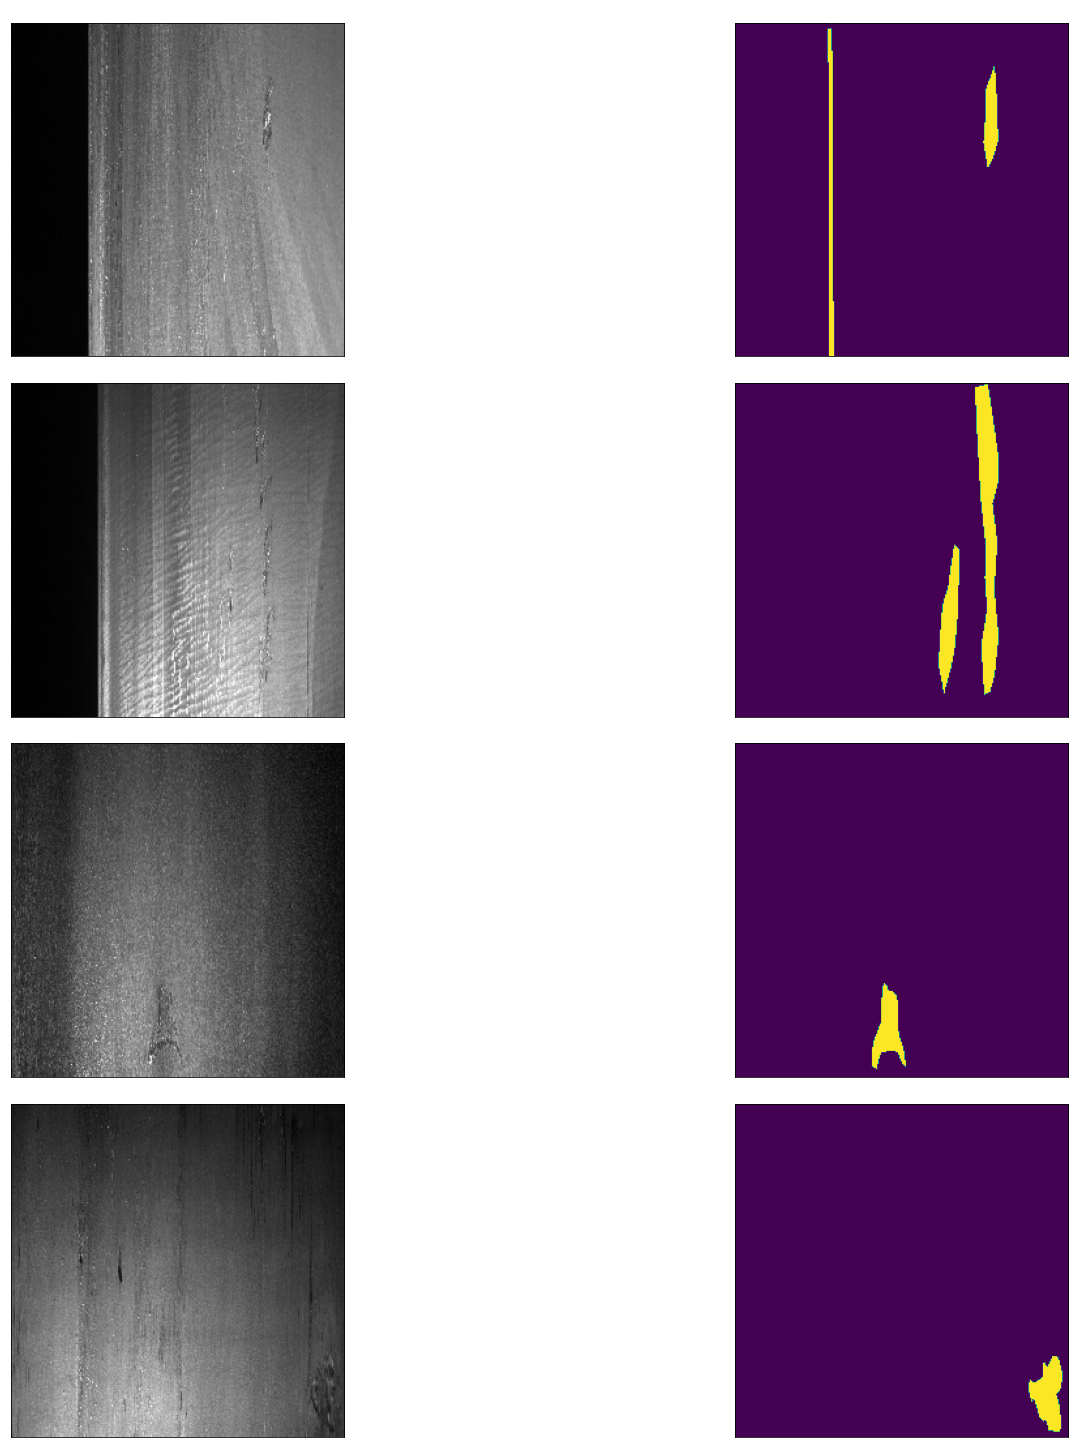

In [ ]:
# Visualising generator output
trialGen = SteelDataGenerator(df = df)
v_samples = next(iter(trialGen))
visualize(v_samples, n_samples=4)

In [ ]:
class ConvLayer(tf.keras.layers.Layer):
    
    def __init__(self, numKernels, kernelSize, strides, padding = "same", n_convs=3, activation = "relu", pool=True):
        super(ConvLayer, self).__init__() 
        
        self.pool = pool

        self.convLayers = models.Sequential([
            layers.Conv2D(
                numKernels, kernelSize, strides=strides, 
                padding=padding, activation=activation
            )
        ] * n_convs)

        self.pooling = layers.MaxPool2D(pool_size=(2, 2))

    def call(self, x):

        x = self.convLayers(x)
        if self.pool == True:
            x = self.pooling(x)         
        return x 


class VGGNet(tf.keras.models.Model):

    def __init__(self, n_classes=1000):
        super(VGGNet, self).__init__()

        self.conv1 = ConvLayer(numKernels=64, kernelSize=(3, 3), strides=1, n_convs=2)
        self.conv2 = ConvLayer(numKernels=128, kernelSize=(3, 3), strides=1, n_convs=2)
        self.conv3 = ConvLayer(numKernels=256, kernelSize=(3, 3), strides=1, n_convs=3)
        self.conv4 = ConvLayer(numKernels=512, kernelSize=(3, 3), strides=1, n_convs=3)
        self.conv5 = ConvLayer(numKernels=512, kernelSize=(3, 3), strides=1, n_convs=3) 

        # self.flat = layers.Flatten()
        # self.dense = layers.Dense(n_classes, activation="relu") 

        self.upsample = layers.UpSampling2D(32, interpolation="bilinear") 
        self.convUp = layers.Conv2D(1, (1, 1), activation = "sigmoid") 


    def call(self, input_tensor):
        # downSampled = self.striding(input_tensor)

        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        # x = self.flat(x)
        # x = self.dense(x)

        x = self.upsample(x)
        x = self.convUp(x)

        return x

    def build_graph(self, inShape = (HEIGHT, WIDTH, CHANNELS)):
        x = layers.Input(shape=inShape)
        return models.Model(inputs = [x], outputs = self.call(x)) 

In [ ]:
vggModel = VGGNet().build_graph()
vggModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv_layer (ConvLayer)       (None, 128, 128, 64)      640       
_________________________________________________________________
conv_layer_1 (ConvLayer)     (None, 64, 64, 128)       73856     
_________________________________________________________________
conv_layer_2 (ConvLayer)     (None, 32, 32, 256)       295168    
_________________________________________________________________
conv_layer_3 (ConvLayer)     (None, 16, 16, 512)       1180160   
_________________________________________________________________
conv_layer_4 (ConvLayer)     (None, 8, 8, 512)         2359808   
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 256, 512)     0     

In [ ]:
lenDf = len(df)
split = int(0.8*lenDf)

X_df = df[:split]
Y_df = df[split:] 

trainGen = SteelDataGenerator(df = X_df)
valGen = SteelDataGenerator(df = Y_df)

vggModel.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)

vggHist = vggModel.fit(trainGen, epochs=50, validation_data=valGen)

2021-11-09 15:39:56.456560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-09 15:40:01.590958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300
2021-11-09 15:40:03.859011: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-09 15:40:04.122842: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-09 15:40:04.122905: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-11-09 15:40:04.424767: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.1

ResourceExhaustedError:  OOM when allocating tensor with shape[32,256,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/up_sampling2d/resize/ResizeBilinear (defined at tmp/ipykernel_88336/3854607943.py:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1351]

Errors may have originated from an input operation.
Input Source operations connected to node model/up_sampling2d/resize/ResizeBilinear:
 model/conv_layer_4/max_pooling2d_4/MaxPool (defined at tmp/ipykernel_88336/2695067331.py:21)

Function call stack:
train_function


### Q.2. Implement FCN8 model using Keras/Tensorflow library for Building footprint segmentation from aerial remote sensing images 

#### <a>https://github.com/menvuthy/building-footprint-dataset</a> 
#### For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Dice Loss function. For better training performance, you can use batch-normalization and dropout if necessary.

#### (i)Plot a comparative loss curve for at least 50 epochs. 
#### (ii) Print confusion matrix, calculate overall as well as classwise classification metrics such as bulding and Background accuracy, Segmentation Accuracy, Dice Coefficient, IoU) on test dataset.

In [ ]:
import numpy as np 
import cv2 
from PIL import Image 

import seaborn as sns 
from matplotlib import pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import models, layers 

import os 
from tqdm import *
import pandas as pd 

imgPaths = "../../NNDL_Datasets/Assignment6/Q3_dataset/Data/image"
maskPaths = "../../NNDL_Datasets/Assignment6/Q3_dataset/Data/mask"

In [ ]:
tf.config.list_physical_devices("GPU")

2021-11-11 15:32:09.292094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:09.297707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:09.297949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
ip = os.listdir(imgPaths)
imagePaths_ = [os.path.join(imgPaths, i) for i in ip]

mp = os.listdir(maskPaths)
maskPaths_ = [os.path.join(maskPaths, i) for i in mp]

df = pd.DataFrame({
    "Image" : imagePaths_, 
    "Mask": maskPaths_
})

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32 
LR = 0.01 

WIDTH = HEIGHT = 512
CHANNELS=3

In [ ]:
class AerialDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, dim = (HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):

        self.data = df 
        self.batch_size = batch_size 
        self.idx = self.data.index.tolist()
        self.dim = dim 

        self.channels = n_channels
        self.shuffle = shuffle 
        self.min_depth = 0.1 

        self.on_epoch_end() 

    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size)) 

    def __getitem__(self, idx):
        if (idx+1)*self.batch_size > len(self.idx):
            self.batch_size = len(self.idx) - idx*self.batch_size 

        idx = self.idx[idx*self.batch_size : (idx+1)*self.batch_size] 
        batch = [self.idx[k] for k in idx]
        x, y = self.__data_generation(batch)
        return x, y 

    def on_epoch_end(self):
        self.idx = np.arange(len(self.idx)) 
        if self.shuffle:
            np.random.shuffle(self.idx) 


    def load(self, img_path, mask_path):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)/255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
        mask = mask > 0.5 
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, -1) 
        img = tf.image.convert_image_dtype(img, tf.float32)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        return img, mask


    def __data_generation(self, batch):
        x = np.empty((self.batch_size, *self.dim, self.channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for idx, batch_idx in enumerate(batch):
            x[idx, :], y[idx, :] = self.load(self.data["Image"][batch_idx], self.data["Mask"][batch_idx])

        return x, y 

In [ ]:
def visualize(samples, n_samples, model=None):
    x, y = samples 

    if model is not None:
        fig, ax = plt.subplots(n_samples, 3, figsize = (15, 10), constrained_layout=True)
        pred = model.predict(x) 
        for i in range(n_samples):
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i, 1].imshow(y[i])
            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            ax[i, 1].set_title("Ground Truth", color="white")

            ax[i, 2].imshow(pred[i])
            ax[i, 2].set_xticks([])
            ax[i, 2].set_yticks([])
            ax[i, 2].set_title("Predicted", color="white")
         

    else :
        fig, ax = plt.subplots(n_samples, 2, figsize = (20, 20), constrained_layout=True)
        for i in range(n_samples): 
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i][1].imshow(y[i])
            ax[i][1].set_xticks([])
            ax[i][1].set_yticks([])
            ax[i][1].set_title("Output", color="white")


2021-11-11 15:32:13.252314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 15:32:13.253381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:13.254232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:13.254542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

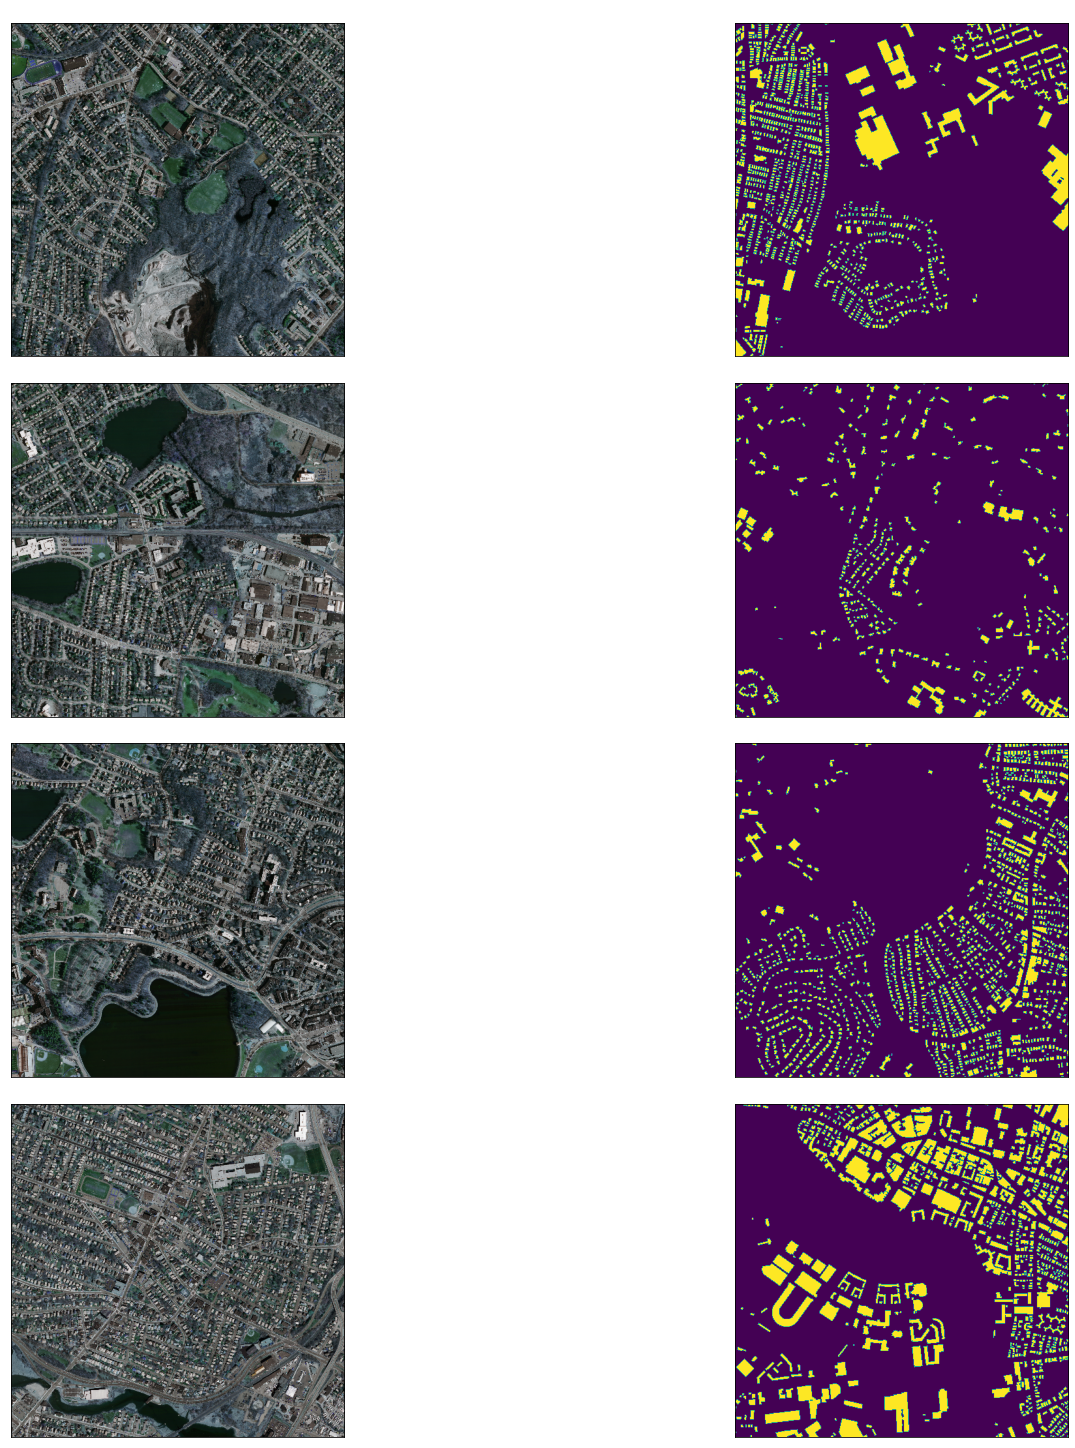

In [ ]:
trialGen = AerialDataGenerator(df = df)
v_samples = next(iter(trialGen))
visualize(v_samples, n_samples=4)

### Q.3. Implement FCN8 model using Keras/Tensorflow library for Building footprint segmentation from aerial remote sensing images (https://github.com/menvuthy/building-footprint-dataset). For implementation, split dataset into training dataset (80%) and  testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for  Dice Loss function. For better training performance, you can use batch-normalization and dropout if necessary.  
### (i)Plot a comparative loss curve for at least 50 epochs. (ii) Print confusion matrix, calculate overall  as well as classwise classification metrics such as  bulding and Background accuracy, Segmentation Accuracy, Dice Coefficient, IoU) on test dataset. 


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
torch.set_default_dtype(torch.float32)
torch.manual_seed(42)

In [ ]:
''' model.py '''

import torch
import torch.nn as nn
torch.set_default_dtype(torch.float32)

class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # First
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # Second
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class ConvTranspose(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvTranspose, self).__init__()
        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, 
                kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=0, bias=True
            ),
            nn.ReLU()            
        )

    def forward(self, x):
        return self.conv_transpose(x)

class FCN(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(FCN, self).__init__()
        # Init
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Downsamplers
        self.dp1 = nn.MaxPool2d((2, 2))
        self.dp2 = nn.MaxPool2d((2, 2))
        self.dp3 = nn.MaxPool2d((2, 2))
        # Convolutions
        self.dc1 = DoubleConv(in_channels, 64)
        self.dc2 = DoubleConv(64, 128)
        self.dc3 = DoubleConv(128, 256)
        self.dc4 = DoubleConv(256, 512)
        self.uc3 = DoubleConv(256 * 2, 256)
        self.uc2 = DoubleConv(128 * 2, 128)
        self.uc1 = DoubleConv(64 * 2, 64)
        # Upsamplers
        self.up3 = ConvTranspose(512, 256)
        self.up2 = ConvTranspose(256, 128)
        self.up1 = ConvTranspose(128, 64)
        # Final conv
        self.fc = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        dc1 = self.dc1(x)
        dp1 = self.dp1(dc1)
        dc2 = self.dc2(dp1)
        dp2 = self.dp2(dc2)
        dc3 = self.dc3(dp2)
        dp3 = self.dp3(dc3)
        dc4 = self.dc4(dp3)
        # Decoder
        up3 = self.up3(dc4)
        cat = torch.cat([up3, dc3], dim=1)
        uc3 = self.uc3(cat)
        #
        up2 = self.up2(uc3)
        cat = torch.cat([up2, dc2], dim=1)
        uc2 = self.uc2(cat)
        #
        up1 = self.up1(uc2)
        cat = torch.cat([up1, dc1], dim=1)
        uc1 = self.uc1(cat)
        # Final Conv
        out = self.fc(uc1)
        out = self.sigmoid(out)
        return out

In [ ]:
''' dataset.py - Loads datasets and provides easy access through a dedicated class '''

import os
import random
import nibabel as nib
import numpy as np

class BraTS2018():
    
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def norm(self, image):
        ''' Normalize Image '''
        return (image - np.min(image))/(np.max(image) - np.min(image))
        
    def process(self, sample, idx):
        ''' Resize sample to the given size '''
        sample = np.transpose(sample, (2, 0, 1))
        return sample[idx]
        
    def load(self, glioma, slice_idx=100, shuffle=False, batch_size=4):
        assert glioma in ["HGG", "LGG"]
        # Init
        batch = np.zeros((batch_size, 4, 240, 240))
        targets = np.zeros((batch_size, 1, 240, 240))
        base_dir = self.data_dir + os.path.sep + glioma
        samples = os.listdir(base_dir)
        if shuffle: random.shuffle(samples)
        # Yield samples when batch is full
        i = 0
        for sample in samples:
            sample_dir = base_dir + os.path.sep + sample
            # Read samples
            t1w = nib.load(sample_dir + os.path.sep + f"{sample}_t1.nii").get_fdata().astype('float32')
            t1wpc = nib.load(sample_dir + os.path.sep + f"{sample}_t1ce.nii").get_fdata().astype('float32')
            t2w = nib.load(sample_dir + os.path.sep + f"{sample}_t2.nii").get_fdata().astype('float32')
            flair = nib.load(sample_dir + os.path.sep + f"{sample}_flair.nii").get_fdata().astype('float32')
            seg = nib.load(sample_dir + os.path.sep + f"{sample}_seg.nii").get_fdata().astype('float32')
            # Add to batch
            batch[i%batch_size, 0] = self.norm(self.process(t1w, slice_idx))
            batch[i%batch_size, 1] = self.norm(self.process(t1wpc, slice_idx))
            batch[i%batch_size, 2] = self.norm(self.process(t2w, slice_idx))
            batch[i%batch_size, 3] = self.norm(self.process(flair, slice_idx))
            targets[i%batch_size, 0] = self.process(seg, slice_idx) 
            # Yield every batch
            i += 1
            if i > 0 and (i%batch_size) == 0:
                yield batch, targets

In [ ]:
# Test data loader
brats = BraTS2018("/kaggle/input/brats2018/MICCAI_BraTS_2018_Data_Training")
for batch, targets in brats.load("HGG", 100, shuffle=False):
    print(batch.shape, targets.shape)
    print(np.unique(targets))
    break

(4, 4, 240, 240) (4, 1, 240, 240)
[0. 1. 2. 4.]


In [ ]:
brats = BraTS2018("/kaggle/input/brats2018/MICCAI_BraTS_2018_Data_Training")

In [ ]:
# Hyperparameters
epochs = 50
learning_rate = 2.5e-3

In [ ]:
in_channels = 4
out_channels = 1
model = FCN(in_channels, out_channels)
model.cuda()

FCN(
  (dp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dp3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

In [ ]:
def dice_loss(predictions, targets, alpha=0.7, beta=0.3, gamma=4/3, smooth=1):
#     # Dice
#     predictions = predictions.view(-1)
#     targets = targets.view(-1)
#     intersection = (predictions * targets).sum()
#     dice = (2 * intersection + smooth) / (predictions.sum() + targets.sum() - intersection + smooth)
#     return -1 * dice
    # FocalTversky
    TP = (predictions * targets).sum()    
    FP = ((1 - targets) * predictions).sum()
    FN = (targets * (1 - predictions)).sum()
    Tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)  
    FocalTversky = (1 - Tversky) ** gamma
    return FocalTversky
#     # Focal Loss
#     BCE = nn.functional.binary_cross_entropy(predictions, targets, reduction='mean')
#     BCE_EXP = torch.exp(-BCE)
#     focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE
#     return focal_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
n_test_samples = 100
train_avg_losses = []
test_avg_losses = []
start_time = time.time()

for epoch in range(epochs):
    
    epoch_start_time = time.time()
    
    train_losses = []
    test_losses = []
    n_train_samples = 0
    
    for batch, targets in brats.load("HGG", 100, shuffle=True):
        n_train_samples += 1
        # Convert samples to one-hot form
        batch = torch.tensor(batch)
        targets = torch.tensor(targets)
        targets_one_hot = targets > 0
        # Copy to GPU
        batch = batch.float().cuda()
        targets = targets_one_hot.float().cuda()
        # Train
        optimizer.zero_grad()
        outputs = model(batch)
        loss = dice_loss(outputs, targets) 
        train_losses.append(float(loss))
        loss.backward()
        optimizer.step()
        del batch
        del targets
        del outputs
        torch.cuda.empty_cache()

    i = 0
    for batch, targets in brats.load("HGG", 100, True):
        i += 1 
        if i > n_test_samples: break
        # Convert samples to one-hot form
        batch = torch.tensor(batch)
        targets = torch.tensor(targets)
        targets_one_hot = targets > 0
        # Copy to GPU
        batch = batch.float().cuda()
        targets = targets_one_hot.float().cuda()
        # Forward Propagation
        with torch.no_grad():
            outputs = model(batch)
            loss = dice_loss(outputs, targets)
            test_losses.append(float(loss))
        del batch
        del targets
        del outputs
        torch.cuda.empty_cache()
    
    train_avg_loss = sum(train_losses) / n_train_samples
    test_avg_loss = sum(test_losses) / n_test_samples
    train_avg_losses.append(train_avg_loss)
    test_avg_losses.append(test_avg_loss)

    epoch_time_stamp = int(time.time() - start_time)
    epoch_end_time = int(time.time() - epoch_start_time)
    print(f"EPOCH {(epoch + 1)}/{epochs}  TRAIN:{train_avg_loss}  TEST:{test_avg_loss}  TOOK:{epoch_end_time}s (t:{epoch_time_stamp}s)")
    if ((epoch+1) % 10) == 0:
        torch.save(model.state_dict(), f"assignment-model-{(epoch+1)}.torch")

EPOCH 1/50  TRAIN:0.809003760608343  TEST:0.3423269855976105  TOOK:370s (t:370s)
EPOCH 2/50  TRAIN:0.36865207889618784  TEST:0.16351363327354193  TOOK:258s (t:629s)
EPOCH 3/50  TRAIN:0.25061231160249847  TEST:0.11286678541451693  TOOK:256s (t:886s)
EPOCH 4/50  TRAIN:0.18447032599495009  TEST:0.09418001167476177  TOOK:247s (t:1133s)
EPOCH 5/50  TRAIN:0.24273435176851657  TEST:0.12714188830927015  TOOK:257s (t:1390s)
EPOCH 6/50  TRAIN:0.19772119433260882  TEST:0.12035687439143658  TOOK:251s (t:1641s)
EPOCH 7/50  TRAIN:0.21793894570034283  TEST:0.08862736146897078  TOOK:251s (t:1892s)
EPOCH 8/50  TRAIN:0.20900931639166978  TEST:0.07776756922714412  TOOK:252s (t:2145s)
EPOCH 9/50  TRAIN:0.20401856095458454  TEST:0.0989910357259214  TOOK:243s (t:2388s)
EPOCH 10/50  TRAIN:0.18721099856954354  TEST:0.08692438066005707  TOOK:261s (t:2650s)
EPOCH 11/50  TRAIN:0.21182147631994808  TEST:0.09143023118376732  TOOK:254s (t:2904s)
EPOCH 12/50  TRAIN:0.18598229584928888  TEST:0.09740445507690311  TOOK

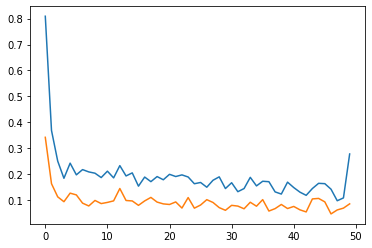

In [ ]:
plt.plot(range(len(train_avg_losses)), train_avg_losses);
plt.plot(range(len(test_avg_losses)), test_avg_losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), "final_model.torch")

SAMPLE #1


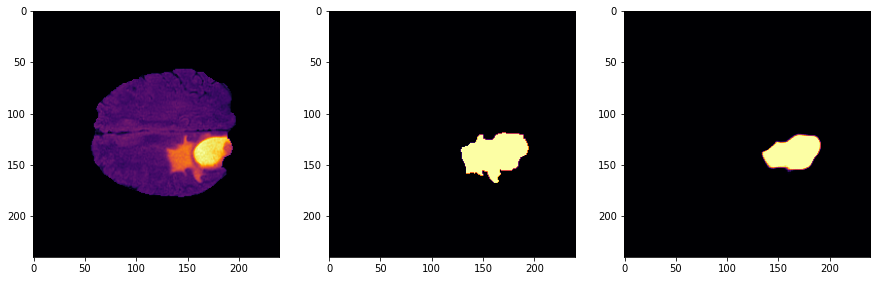

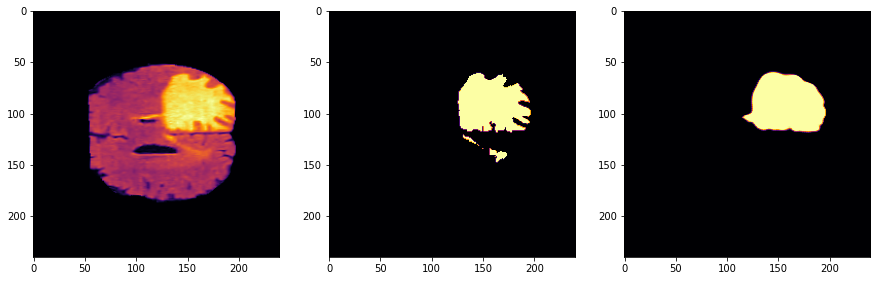

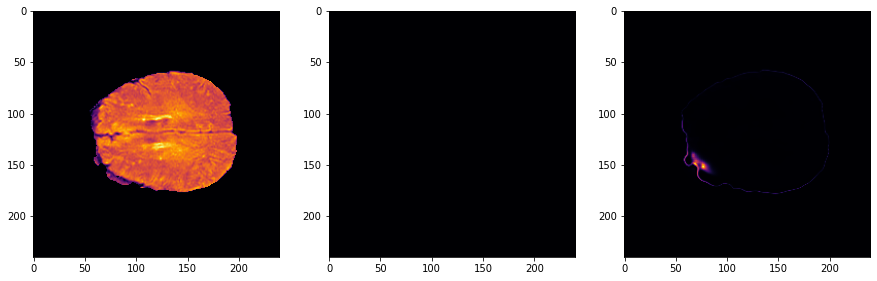

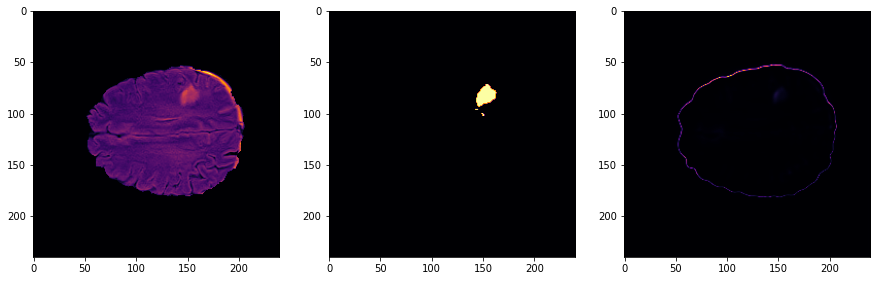

SAMPLE #2


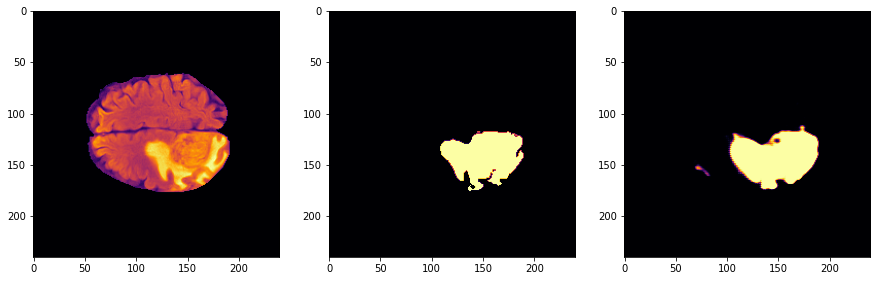

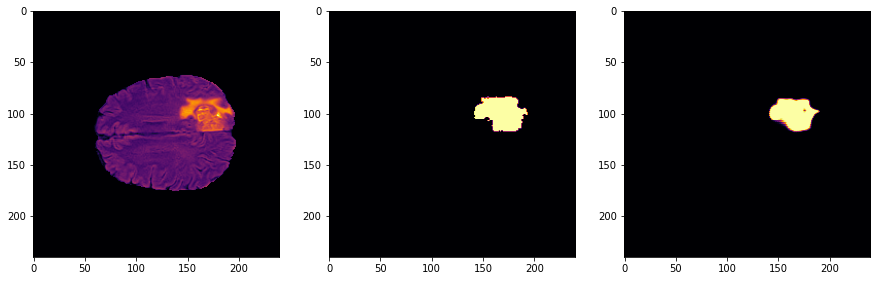

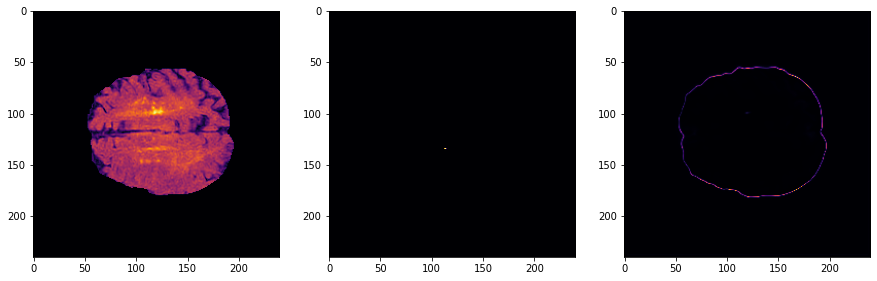

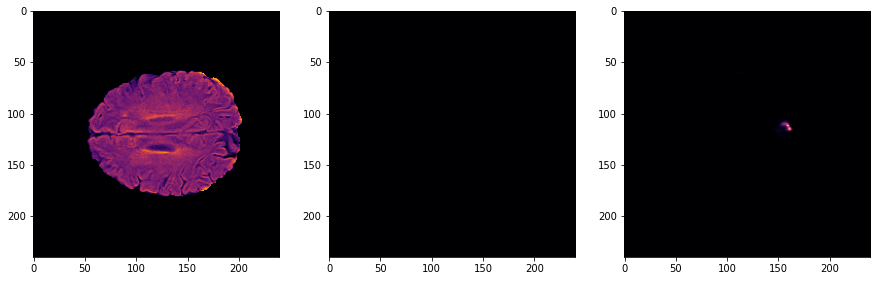

SAMPLE #3


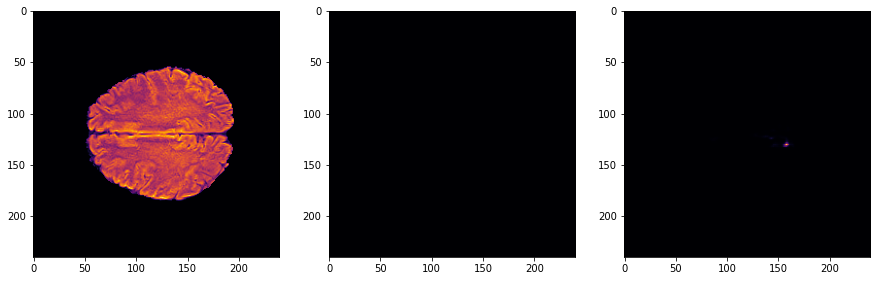

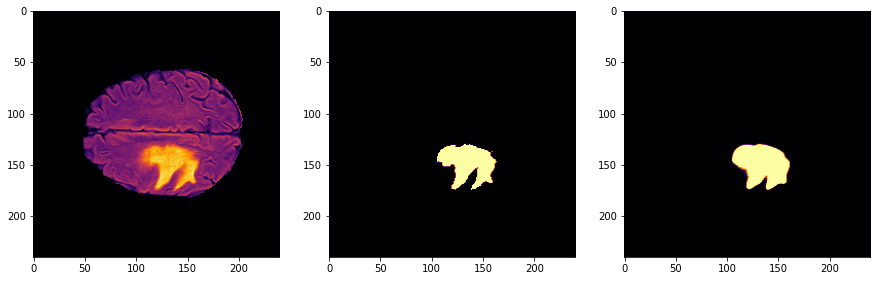

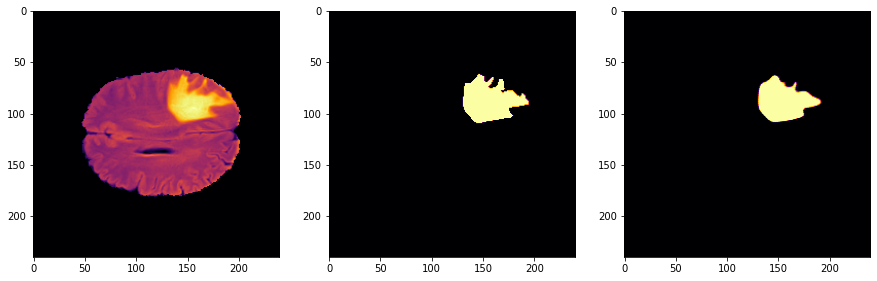

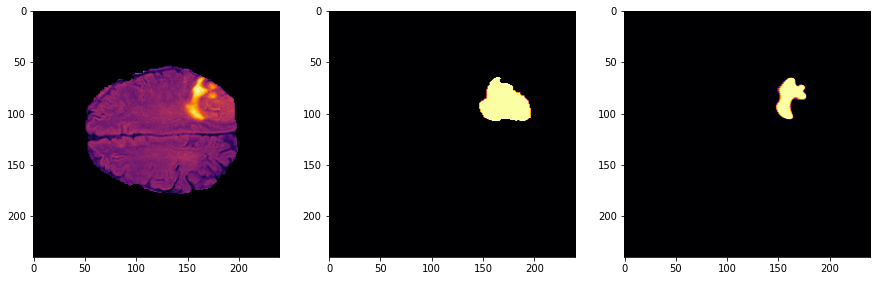

SAMPLE #4


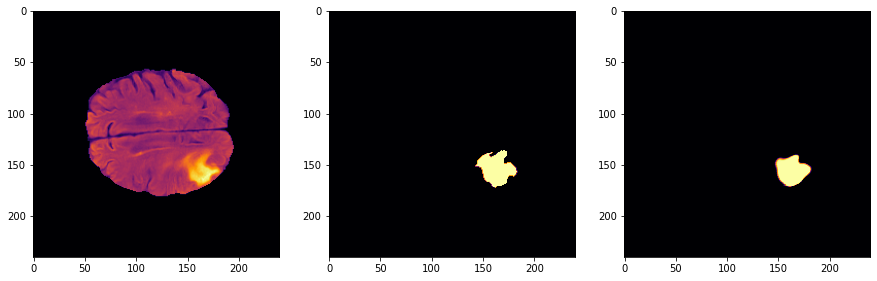

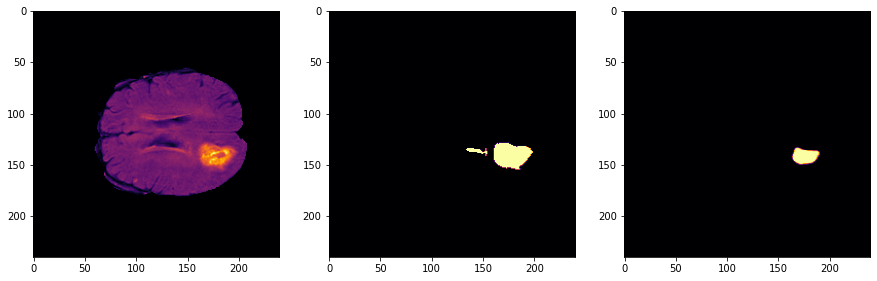

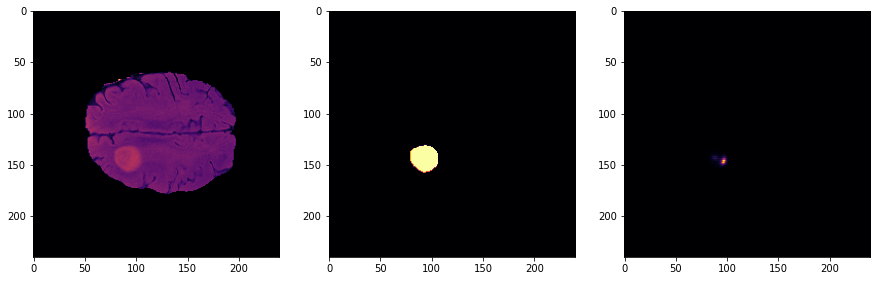

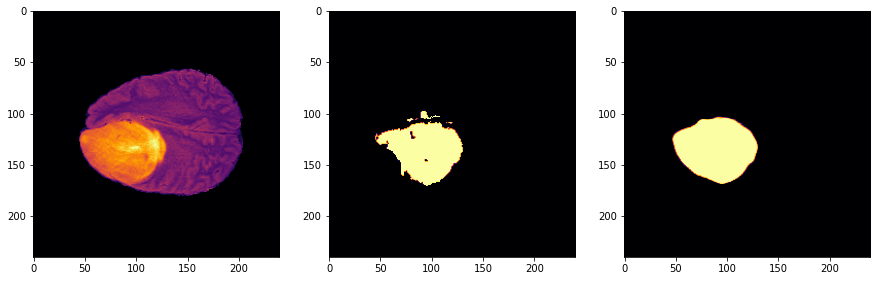

SAMPLE #5


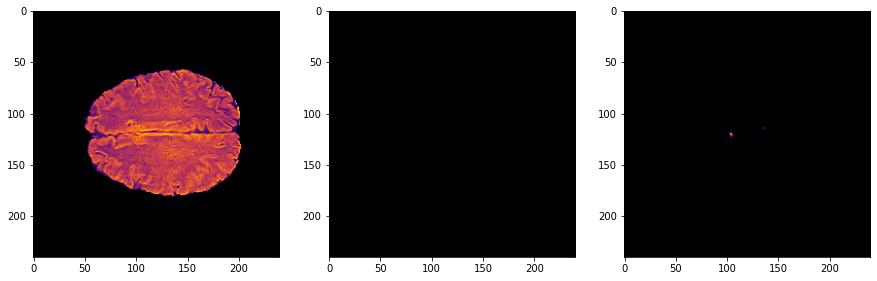

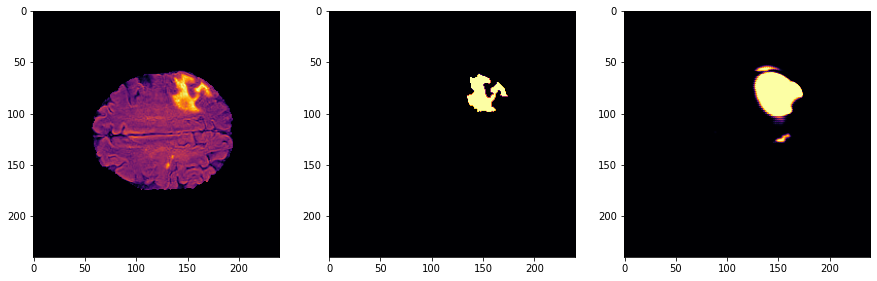

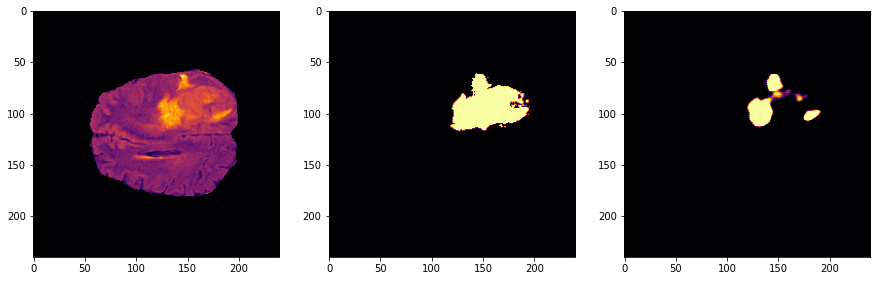

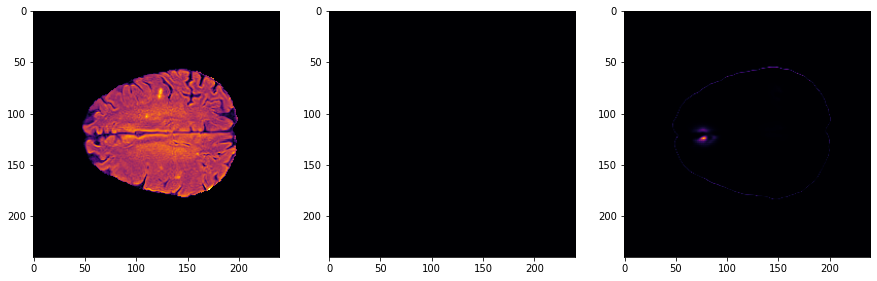

SAMPLE #6


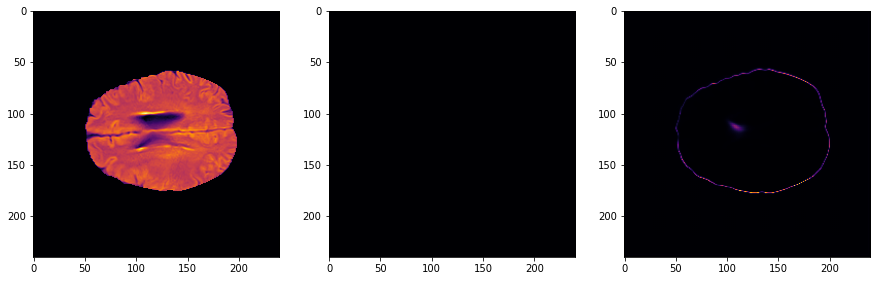

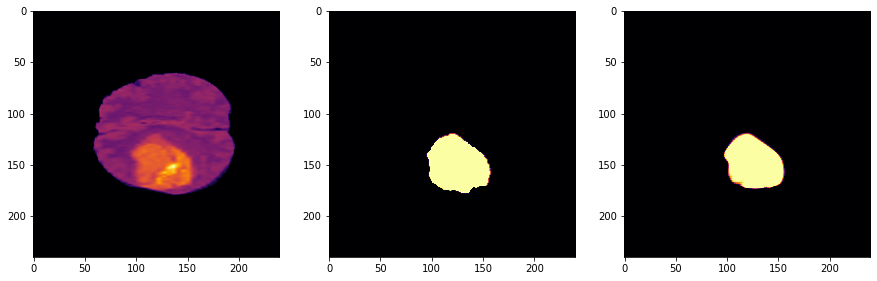

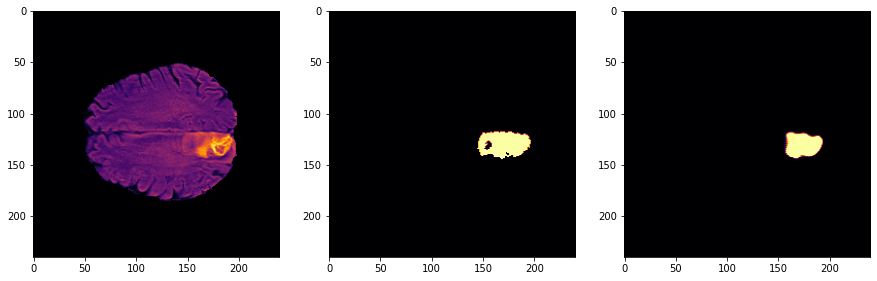

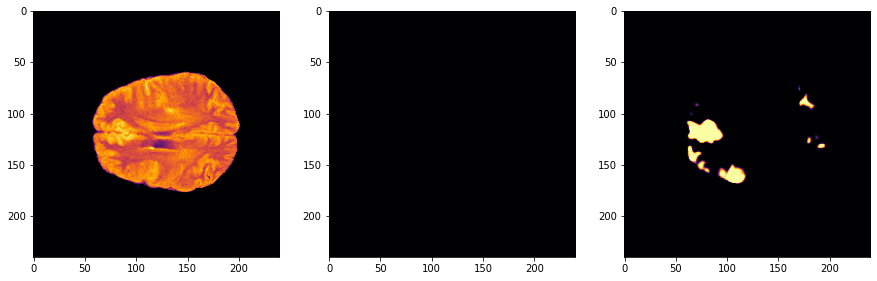

In [ ]:
# Plot some samples and compare the results
n = 6
i = 0
for batch, targets in brats.load("HGG", 100, True):
    i += 1
    if i > n: break
    # Convert samples to one-hot form
    batch = torch.tensor(batch)
    targets = torch.tensor(targets)
    targets_one_hot = targets > 0
    # Copy to GPU
    batch = batch.float().cuda()
    targets = targets_one_hot.float().cuda()
    # Forward Propagation
    with torch.no_grad(): 
        outputs = model(batch)
    # Plot outputs
    print(f"SAMPLE #{i}")
    for j in range(4):
        mapped_input = batch[j].cpu()
        mapped_target = targets_one_hot[j].cpu()
        mapped_output = outputs[j].cpu()
        cm = "inferno"
        fig, ax = plt.subplots(1, 3, figsize=(15, 15))
        ax[0].imshow(mapped_input[3], cmap=cm) # Flair
        ax[1].imshow(mapped_target[0], cmap=cm)
        ax[2].imshow(mapped_output[0], cmap=cm)
        plt.show()
    # Clear Cache
    del batch
    del targets
    del outputs
    torch.cuda.empty_cache()

### Q.4.Implement U-Net model for the multi-class schematic segmentation of aerial images (Dataset: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery). Use an Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the model for  Softmax loss  function. For better training performance, you can use batch-normalization and dropout if necessary.
### (i)Plot a comparative loss curve for at least 50 epochs. (ii)Print confusion matrix, calculate overall  as well as class-wise classification metrics such as precision, recall, F1-score, IoU, Accuracy on test datset. 


In [ ]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import numpy as np


#reading images and resizing them into the same shape
root='../input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/'
imagearray=[]

for path,subs,files in os.walk(root):
    dirname=path.split(os.path.sep)[-1]
    if dirname=="images":
        images=os.listdir(path)
        for i,name in enumerate(images):
            if name.endswith(".jpg"):

                image=cv2.imread(path+"/"+name,1)
                image=cv2.resize(image,(256,256))
                image=np.array(image)
                imagearray.append(image)

maskarray=[]

for path,subs,files in os.walk(root):
    dirname=path.split(os.path.sep)[-1]
    if dirname=="masks":
        masks=os.listdir(path)
        for i,M_name in enumerate(masks):
            if M_name.endswith(".png"):

                mask =cv2.imread(path+"/"+M_name,1)
                mask =cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                mask =cv2.resize(mask,(256,256))
                mask =np.array(mask)
                maskarray.append(mask)

imagedata = np.array(imagearray)
maskdata =  np.array(maskarray)



In [ ]:
Building=np.array([60,16,152])
Land=np.array([132,41,246])
road=np.array([110,193,228])
Vegetation=np.array([254,221,58])
water=np.array([226,169,41])
Unlabeled =np.array([155,155,155])

label = maskdata

def flatLabels(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(maskdata.shape[0]):
    label = flatLabels(maskdata[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
#one hot encoding to_categorical

n_classes = len(np.unique(labels))
from keras.utils.np_utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

!pip install segmentation-models==1.0.1
import keras
from keras.utils import generic_utils
import segmentation_models as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imagedata, labels_cat, test_size = 0.20)

#those weights are optional, (automatically will be set all weights to 1)

weights = [0.155, 0.155, 0.155, 0.155, 0.155, 0.155]

dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal=sm.losses.CategoricalFocalLoss()
total=dice_loss+(1*focal)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 654.5 kB/s eta 0:00:00a 0:00:01
Segmentation Models: using `keras` framework.


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, \
    Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def unet(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # begin with contraction part
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    # define output layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])


    return model


In [ ]:
def focal_loss(alpha=0.001, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    targets = tf.cast(targets, tf.float32)
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, logits):
    y_pred = tf.math.sigmoid(logits)
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    return tf.reduce_mean(loss)

  return loss

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]



metrics=['accuracy', jacard_coef]

def get_model():
    return unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=focal_loss(), metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

2022-04-14 16:14:08.525330: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

2022-04-14 16:14:09.236138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
4/4 [==============================] - 21s 4s/step - loss: 0.2112 - accuracy: 0.2385 - jacard_coef: 0.1411 - val_loss: 0.2010 - val_accuracy: 0.3544 - val_jacard_coef: 0.2154
Epoch 2/50
4/4 [==============================] - 15s 4s/step - loss: 0.1945 - accuracy: 0.4291 - jacard_coef: 0.2711 - val_loss: 0.1984 - val_accuracy: 0.3855 - val_jacard_coef: 0.2388
Epoch 3/50
4/4 [==============================] - 16s 4s/step - loss: 0.1907 - accuracy: 0.4729 - jacard_coef: 0.3052 - val_loss: 0.1983 - val_accuracy: 0.3858 - val_jacard_coef: 0.2390
Epoch 4/50
4/4 [==============================] - 15s 4s/step - loss: 0.1905 - accuracy: 0.4747 - jacard_coef: 0.3067 - val_loss: 0.1983 - val_accuracy: 0.3858 - val_jacard_coef: 0.2390
Epoch 5/50
4/4 [==============================] - 16s 4s/step - loss: 0.1905 - accuracy: 0.4749 - jacard_coef: 0.3069 - val_loss: 0.1983 - val_accuracy: 0.3858 - val_jacard_coef: 0.2390
Epoch 6/50
4/4 [==============================] - 15s 4s/step - loss: 

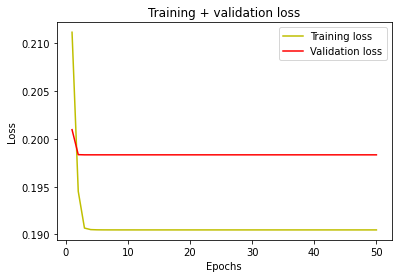

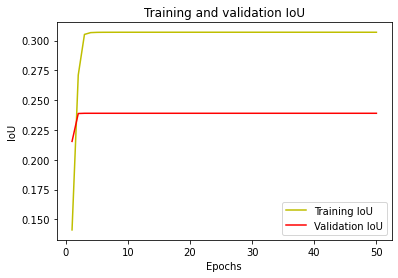

In [ ]:
from matplotlib import pyplot as plt
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training + validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Q.5


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

In [ ]:
depthwise_filter = np.array([[[1, 2, 1], [2, 4, 2], [1, 2, 1]], [[1, 2, 1], [2, 4, 2], [1, 2, 1]], [[1, 2, 1], [2, 4, 2], [1, 2, 1]]])/16 
pointwise_filter = np.array([[1], [1], [1]])/512 

In [ ]:
def depthwise_conv2d(input, w):
    """Two-dimensional depthwise convolution.

    Uses SAME padding with 0s, a stride of 1 and no dilation. A single output
    channel is used per input channel (channel_multiplier=1).

    input: input array with shape (height, width, in_depth)
    w: filter array with shape (fd, fd, in_depth)

    Returns a result with shape (height, width, in_depth).
    """
    assert w.shape[0] == w.shape[1] and w.shape[0] % 2 == 1

    padw = w.shape[0] // 2
    padded_input = np.pad(input,
                          pad_width=((padw, padw), (padw, padw), (0, 0)),
                          mode='constant',
                          constant_values=0)

    height, width, in_depth = input.shape
    assert in_depth == w.shape[2]
    output = np.zeros((height, width, in_depth))

    for c in range(in_depth):
        # For each input channel separately, apply its corresponsing filter
        # to the input.
        for i in range(height):
            for j in range(width):
                for fi in range(w.shape[0]):
                    for fj in range(w.shape[1]):
                        w_element = w[fi, fj, c]
                        output[i, j, c] += (
                            padded_input[i + fi, j + fj, c] * w_element)
    return output

In [ ]:
def separable_conv2d(input, w_depth, w_pointwise):
    """Depthwise separable convolution.

    Performs 2d depthwise convolution with w_depth, and then applies a pointwise
    1x1 convolution with w_pointwise on the result.

    Uses SAME padding with 0s, a stride of 1 and no dilation. A single output
    channel is used per input channel (channel_multiplier=1) in w_depth.

    input: input array with shape (height, width, in_depth)
    w_depth: depthwise filter array with shape (fd, fd, in_depth)
    w_pointwise: pointwise filter array with shape (in_depth, out_depth)

    Returns a result with shape (height, width, out_depth).
    """
    # First run the depthwise convolution. Its result has the same shape as input.
    depthwise_result = depthwise_conv2d(input, w_depth)

    height, width, in_depth = depthwise_result.shape
    assert in_depth == w_pointwise.shape[0]
    out_depth = w_pointwise.shape[1]
    output = np.zeros((height, width, out_depth))

    for out_c in range(out_depth):
        for i in range(height):
            for j in range(width):
                for c in range(in_depth):
                    w_element = w_pointwise[c, out_c]
                    output[i, j, out_c] += depthwise_result[i, j, c] * w_element
    return output

In [ ]:
img = cv2.imread("lenna.tif")
part_a = separable_conv2d(img,depthwise_filter,pointwise_filter)

In [ ]:
part_a.shape

(512, 512, 1)

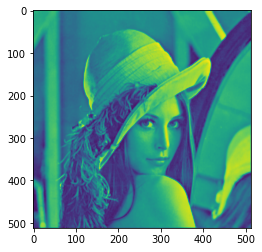

In [ ]:
plt.imshow(part_a[:,:,0])

## Dilated Convolution 2D

In [ ]:
import numpy as np
from typing import List, Tuple, Union


def add_padding(matrix: np.ndarray, 
                padding: Tuple[int, int]) -> np.ndarray:
    """Adds padding to the matrix. 
    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix
    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
    """
    n, m = matrix.shape
    r, c = padding
    
    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix
    
    return padded_matrix


def _check_params(matrix, kernel, stride, dilation, padding):
    params_are_correct = (isinstance(stride[0], int)   and isinstance(stride[1], int)   and
                          isinstance(dilation[0], int) and isinstance(dilation[1], int) and
                          isinstance(padding[0], int)  and isinstance(padding[1], int)  and
                          stride[0]   >= 1 and stride[1]   >= 1 and 
                          dilation[0] >= 1 and dilation[1] >= 1 and
                          padding[0]  >= 0 and padding[1]  >= 0)
    assert params_are_correct, 'Parameters should be integers equal or greater than default values.'
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    n, m = matrix.shape
    matrix = matrix if list(padding) == [0, 0] else add_padding(matrix, padding)
    n_p, m_p = matrix.shape

    if not isinstance(kernel, np.ndarray):
        kernel = np.array(kernel)
    k = kernel.shape
    
    kernel_is_correct = k[0] % 2 == 1 and k[1] % 2 == 1
    assert kernel_is_correct, 'Kernel shape should be odd.'
    matrix_to_kernel_is_correct = n_p >= k[0] and m_p >= k[1]
    assert matrix_to_kernel_is_correct, 'Kernel can\'t be bigger than matrix in terms of shape.'
    
    h_out = np.floor((n + 2 * padding[0] - k[0] - (k[0] - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - k[1] - (k[1] - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    out_dimensions_are_correct = h_out > 0 and w_out > 0
    assert out_dimensions_are_correct, 'Can\'t apply input parameters, one of resulting output dimension is non-positive.'

    return matrix, kernel, k, h_out, w_out


def conv2d(matrix: Union[List[List[float]], np.ndarray], 
             kernel: Union[List[List[float]], np.ndarray], 
             stride: Tuple[int, int] = (1, 1), 
             dilation: Tuple[int, int] = (1, 1), 
             padding: Tuple[int, int] = (0, 0)) -> np.ndarray:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.
    Args:
        matrix (Union[List[List[float]], np.ndarray]): 2D matrix to be convolved.
        kernel (Union[List[List[float]], np.ndarray]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).
    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    matrix, kernel, k, h_out, w_out = _check_params(matrix, kernel, stride, dilation, padding)
    matrix_out = np.zeros((h_out, w_out))
    
    b = k[0] // 2, k[1] // 2
    center_x_0 = b[0] * dilation[0]
    center_y_0 = b[1] * dilation[1]
    for i in range(h_out):
        center_x = center_x_0 + i * stride[0]
        indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
        for j in range(w_out):
            center_y = center_y_0 + j * stride[1]
            indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

            submatrix = matrix[indices_x, :][:, indices_y]

            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out

def apply_filter_to_image(image: np.ndarray, 
                          kernel: List[List[float]],
                          dilation: Tuple[int, int] = (1, 1) ) -> np.ndarray:
    """Applies filter to the given image.
    Args:
        image (np.ndarray): 3D matrix to be convolved. Shape must be in HWC format.
        kernel (List[List[float]]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
    Returns:
        np.ndarray: image after applying kernel.
    """
    kernel = np.asarray(kernel)
    b = kernel.shape
    return np.dstack([conv2d(image[:, :, z], kernel, padding=(b[0]//2,  b[1]//2), dilation=dilation) 
                      for z in range(3)]).astype('uint8')    

filter= np.array([[1, 2, 1],[2, 4, 2], [1, 2, 1]])/16
dilation = (3,3)

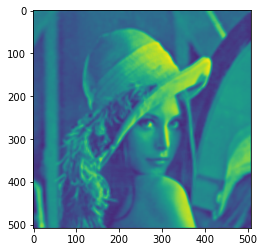

In [ ]:
img = cv2.imread("lenna.tif")
part_b = apply_filter_to_image(img,filter,dilation)

#show the result
plt.imshow(part_b[:,:,0])